# ASTR-19 Final Project!
#### Emerson Tao

_**Note:** This was coded in Google Colab due to issues with my computer running certain packages._

In [1]:
# import libraries
import numpy as np
!pip install sep
import sep

In [2]:
# additional setup for reading the test image and displaying plots
from astropy.io import fits    # using astropy instead of fitsio
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.patches import Ellipse
from google.colab import drive
drive.mount('/content/drive')

%matplotlib inline
rcParams['figure.figsize'] = [10., 8.]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## F105W band image

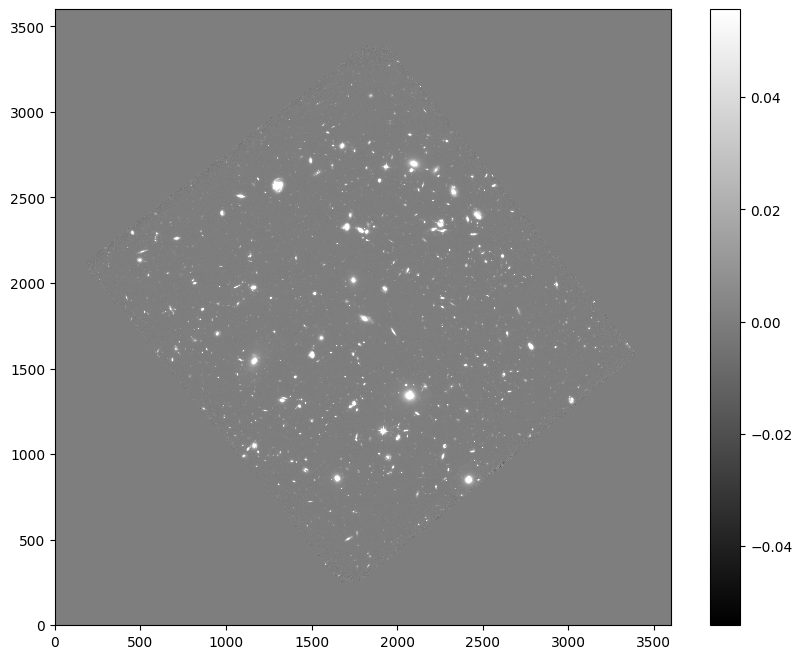

In [3]:
# read f105w band image into standard 2-d numpy array
fdata_F105W = "/content/drive/MyDrive/year1-winter/astr19-programming/astr19-final/hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits"
hdu_105 = fits.open(fdata_F105W)
#primary_hdu2 = hdu2[0]
F105W_data = hdu_105[0].data  # convert into an array
F105W_data = F105W_data.byteswap().newbyteorder()  #trying to correct a common error in astropy fits

# show the image WOO
m,s = np.mean(F105W_data), np.std(F105W_data)   # defining the variables
plt.imshow(F105W_data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')   # creating the plot
plt.colorbar();   # adding color bar!

In [4]:
# find and evaluate background
F105W_bkg = sep.Background(F105W_data)

# evaluate background as 2-d array, same size as original image
bkg_image = F105W_bkg.back()

bkg_rms = F105W_bkg.rms()


# subtract the background
data_sub = F105W_data - F105W_bkg

# find objects
objects = sep.extract(data_sub, 1.5, err=F105W_bkg.globalrms)

len(objects) # how many were found?

8643

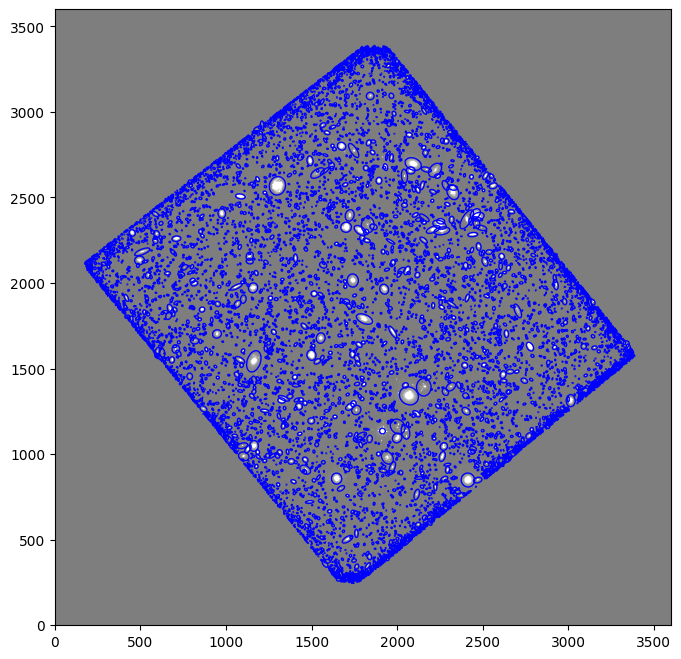

In [5]:
# plot background-subtracted image of this
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('blue')   # each ellipse will be blue
    ax.add_artist(e)

In [6]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],  #"simple" circular aperture photometry
                                     3.0, err=F105W_bkg.globalrms, gain=1.0)     # 3.0 -> 3 pixel radius
# show the first 10 objects results:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))   # print the flux of the 10 objects found

object 0: flux = 0.031282 +/- 0.176890
object 1: flux = 0.031018 +/- 0.176142
object 2: flux = -0.024388 +/- 0.002883
object 3: flux = 0.001947 +/- 0.044219
object 4: flux = 0.012457 +/- 0.111649
object 5: flux = -0.011228 +/- 0.002875
object 6: flux = 0.029368 +/- 0.171394
object 7: flux = -0.009126 +/- 0.002875
object 8: flux = 0.048023 +/- 0.219161
object 9: flux = 0.027840 +/- 0.166877


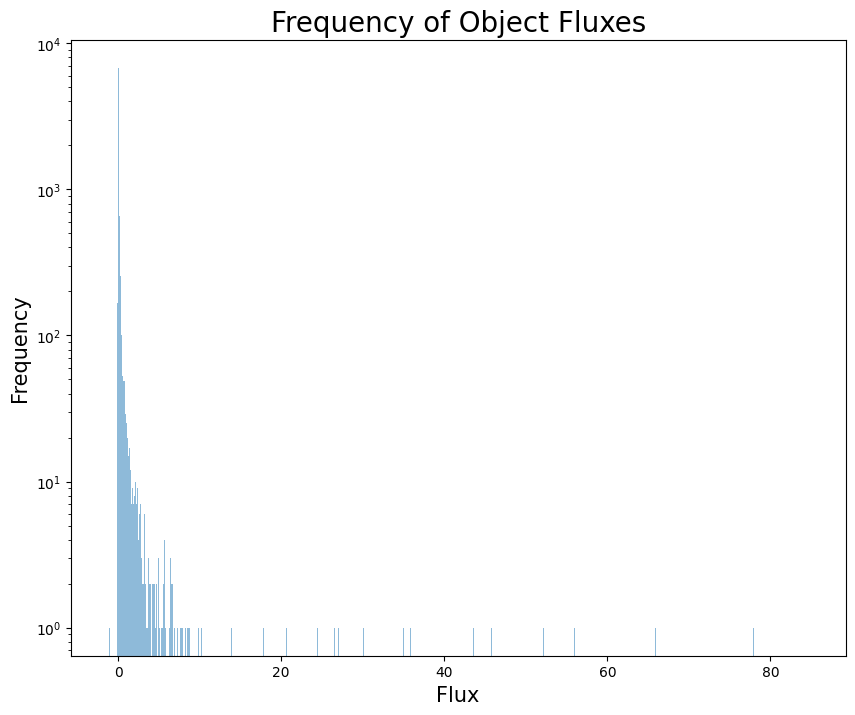

In [7]:
# define bins
width = 0.1
histmin = -1.5
histmax = 85

bins = np.arange(histmin,histmax,width)


# plot the histogram
plt.hist(flux, bins=bins, alpha=0.5)  #edgecolor='black'
plt.yscale('log')   # since there are a LOT of objects
plt.xlabel('Flux', size=15)
plt.ylabel('Frequency', size=15)
plt.title('Frequency of Object Fluxes',size=20)
plt.show()

## Flux Statistics

In [8]:
# find the statistics for the flux:
mean = np.mean(flux)
median = np.median(flux)
std = np.std(flux)

# print out the statistics
print(f'\n Flux Statistics: \n\n The standard deviation of the distribution \
of the fluxes is: {std:5.4} \n The mean of the distribution of the fluxes \
is: {mean:5.4} \n The median of the distribution of the fluxes is: {median:5.4} \n')


 Flux Statistics: 

 The standard deviation of the distribution of the fluxes is: 9.242 
 The mean of the distribution of the fluxes is: 0.3617 
 The median of the distribution of the fluxes is: 0.03095 



In [9]:
# Find the largest outlier-- using z-score

z_scores = np.abs((flux - np.mean(flux)) / np.std(flux))
outliers = np.array((flux)[z_scores > 3], order='A')  # Adjust the threshold as needed
sorted_outies = np.sort(outliers)    # sort the outliers small -> large
length = np.size(outliers)    # how many outliers are there?
largest_outlier = sorted_outies[length-1]    # find the largest outlier (aka: the last value)

print(f'\n The largest outlier is: {largest_outlier:5.4}\n')


 The largest outlier is: 807.3



In [10]:
def deviations(largest_outlier,mean,std):
    # deviations: the number of standard deviations (std) that the observed outlier (largest_outlier) is from the mean flux
    d = ((largest_outlier - mean) / std)
    return d

d = deviations(largest_outlier,mean,s)
print(f'\nThe largest outlier is {d:5.4} standard deviations from the mean.\n')


The largest outlier is 1.471e+04 standard deviations from the mean.



## RGB False-color (F125W, F160W)

In [11]:
# Read f125W and f160W in standard 2-d numpy arrays

# define file names
fdata_F125W = "/content/drive/MyDrive/year1-winter/astr19-programming/astr19-final/hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits"
fdata_F160W = "/content/drive/MyDrive/year1-winter/astr19-programming/astr19-final/hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits"

# read in the data w/ astropy fits
hdu_125 = fits.open(fdata_F125W)
hdu_160 = fits.open(fdata_F160W)

# get the image data
F105W_data = hdu_105[0].data
F125W_data = hdu_125[0].data
F160W_data = hdu_160[0].data

In [12]:
# rescale the image so it, yknow, actually appears on our graph
def rescale_image(data):
    # copy the data to avoid accidentally overwritng it
    pdata_tmp = data.copy()

    # compute the mean value over all data, excluding NaN (Not a Number)
    n = np.nanmean(pdata_tmp)

    # if lower than vpmin, apply vpmin
    # if higher than vpmax, apply vpmax
    vpmin = 0.5*n
    vpmax = 100*n
    pdata_tmp[pdata_tmp < vpmin] = vpmin
    pdata_tmp[pdata_tmp > vpmax] = vpmax
    pdata_tmp = np.nan_to_num(pdata_tmp,nan=vpmin)

    # apply logscale
    pdata_tmp = np.log10(pdata_tmp)
    return pdata_tmp

In [13]:
# use these rescaled data sets for the different filters
F105W_data_res = rescale_image(F105W_data)
F125W_data_res = rescale_image(F125W_data)
F160W_data_res = rescale_image(F160W_data)

In [14]:
# Combine data, then use RGB formatting
data_all = np.zeros((F105W_data.shape[0],F105W_data.shape[1],3))    # shape of F125W in two dimensions, then 2 layers

data_all[:,:,0] = F125W_data   #layer 0; red is filter F125W
data_all[:,:,1] = F160W_data   #layer 1; green is filter F160W
data_all[:,:,2] = F105W_data   #layer 2; blue is filter F105W

data_all_res = rescale_image(data_all)

In [15]:
def remap(data):
    # copy the data to avoid accidentally overwritting it
    pdata_tmp = data.copy()
    dmin = pdata_tmp.min()
    dmax = pdata_tmp.max()
    return (pdata_tmp - dmin)/(dmax-dmin)

In [16]:
rgb_image = np.zeros((F105W_data.shape[0], F105W_data.shape[1],2))

rgb_image = remap(data_all_res)

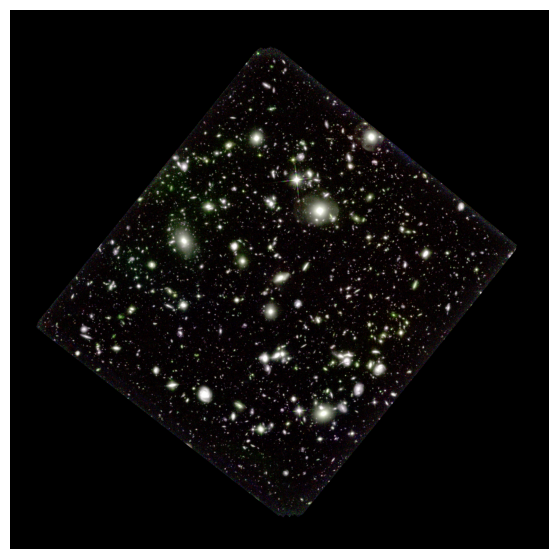

In [17]:
# Plot the RGB image and save to a PNG

f,ax = plt.subplots(1,1,figsize=(7,7))
ax.axis('off')
ax.imshow(rgb_image)
plt.savefig('HUDF_image.png',bbox_inches='tight',pad_inches=0,dpi=600)

#### That's all! Thank you for a great quarter, Dr. Artem and Pedro! 😺